In [249]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

%matplotlib inline

In [157]:
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [158]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [159]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [160]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [161]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [162]:
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [163]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [164]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [165]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [166]:
# step 1: make transactions and marketing indexes as customer_id for easy joining
transactions.set_index('customer_id', inplace=True)
marketing.set_index('customer_id', inplace=True)

In [167]:
# we need to convert key dates to datetime objects
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [168]:
# Merge the customers and engagement DataFrames on 'customer_id'
merged_df = customers.merge(engagement, on='customer_id')

# Merge the result with the transactions DataFrame on 'customer_id'
transaction_level = merged_df.merge(transactions, on='customer_id')

In [169]:
transaction_level.head(15)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics
7,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,8,2023-01-03,492.16,Clothing
8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics
9,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,10,2022-10-20,42.29,Clothing


In [170]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [171]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [172]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [173]:
# Convert remaining dates to datetime objects
transaction_level['join_date'] = pd.to_datetime(transaction_level['join_date'])
transaction_level['last_purchase_date'] = pd.to_datetime(transaction_level['last_purchase_date'])

In [174]:
# reset index
marketing.reset_index(inplace=True)

In [175]:
# make sure sorting is correct
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
0,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
2,1,1,No,Buy One Get One,2024-02-29
3,1,3,No,Free Shipping,2024-03-05


In [176]:
# make sure date datatype is correct
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 984.5+ KB


In [260]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [178]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [179]:
# Drop duplicate customer_id column

df_merged = df_merged.drop(columns=['campaign_customer_id'])


In [180]:
# double check length of final df
len(df_merged)

129545

In [181]:
# double check marketing aligns
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
0,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
2,1,1,No,Buy One Get One,2024-02-29
3,1,3,No,Free Shipping,2024-03-05


In [182]:
transaction_level.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods


In [183]:
# Add LTV column to transactional_level
transaction_level['LTV'] = transaction_level.groupby('customer_id')['transaction_amount'].transform('sum')

In [262]:
# Add LTV column to df_merged
df_merged['LTV'] = transaction_level.groupby('customer_id')['transaction_amount'].transform('sum')

In [184]:
transaction_level.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48


<Axes: ylabel='LTV'>

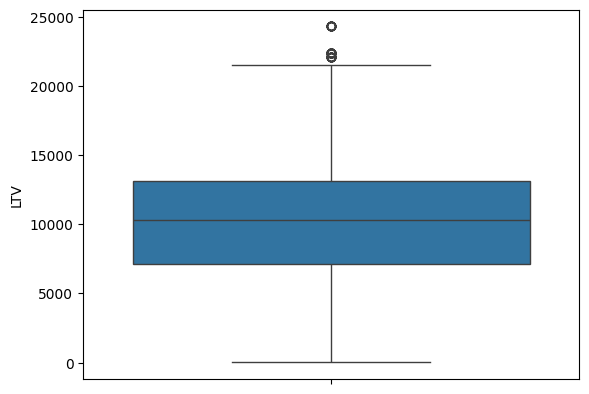

In [185]:
# Investigate outliers of ouput
sns.boxplot(transaction_level['LTV'])

In [186]:
# drop 0 LTV values (we don't want to analyze people who never bought anything)

transaction_level = transaction_level[transaction_level['LTV'] != 0]

In [187]:
# Set outliers to the 99th percentile for better modelling

# Calculate the 99th percentile of the 'transaction_amount' column
percentile_99 = transaction_level['LTV'].quantile(0.99)

# Replace values above the 99th percentile with the 99th percentile value
transaction_level['LTV'] = transaction_level['LTV'].apply(lambda x: min(x, percentile_99))


<Axes: ylabel='LTV'>

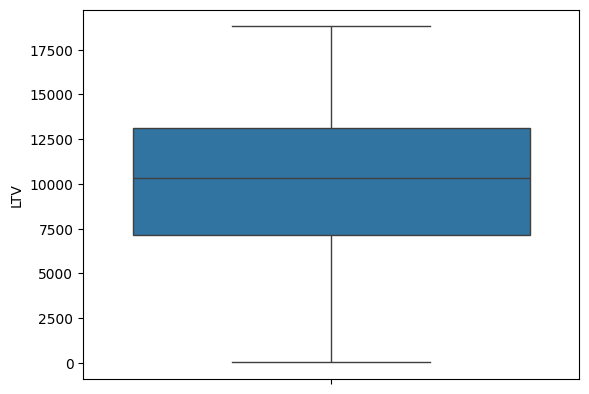

In [188]:
sns.boxplot(transaction_level['LTV'])

In [189]:
transaction_level['LTV'].describe()

count    129545.000000
mean      10096.275322
std        4078.348322
min          23.810000
25%        7134.530000
50%       10324.620000
75%       13103.090000
max       18807.100000
Name: LTV, dtype: float64

In [190]:
# Investigate appropriate Age Bins
customers['age'].describe()

count    8991.000000
mean       43.467467
std        15.094380
min        18.000000
25%        30.000000
50%        44.000000
75%        57.000000
max        69.000000
Name: age, dtype: float64

In [191]:
# Define the age bins and labels
bins = [18, 35, 50, 65, float('inf')]
labels = ['18-34', '35-49', '50-64', '65+']

# Create the age bins and label them
transaction_level['age_bins'] = pd.cut(transaction_level['age'], bins=bins, labels=labels, right=False)

In [192]:
transaction_level['age_bins'].value_counts()

age_bins
18-34    38012
50-64    34075
35-49    32940
65+      11436
Name: count, dtype: int64

In [193]:
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  datetime64[ns]
 2   last_purchase_date       129545 non-null  datetime64[ns]
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [194]:
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64


In [195]:
# Create column to track customer_lifespan
transaction_level['customer_lifespan'] = transaction_level['last_purchase_date'] - transaction_level['join_date']

In [196]:
# Convert lifespan to numeric instead of timedelta

transaction_level['customer_lifespan'] = transaction_level['customer_lifespan'].dt.days

In [197]:
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins,customer_lifespan
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64,118
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64,118
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64,118
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64,118
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64,118
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64,118


In [198]:
transaction_level.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'LTV', 'age_bins',
       'customer_lifespan'],
      dtype='object')

In [199]:
# Investigate output variable to create appropriate ranges to predict
transaction_level['LTV'].describe()

count    129545.000000
mean      10096.275322
std        4078.348322
min          23.810000
25%        7134.530000
50%       10324.620000
75%       13103.090000
max       18807.100000
Name: LTV, dtype: float64

In [200]:
# We want to predict ranges of LTV for better use in model output

# Define the LTV bins and labels
ltv_bins = [0, 7134.53, 10324.62, float('inf')]
ltv_labels = ['Low', 'Medium', 'High']

# Create the LTV_cat column in the transaction_level DataFrame
transaction_level['LTV_cat'] = pd.cut(transaction_level['LTV'], bins=ltv_bins, labels=ltv_labels, right=False)

In [201]:
transaction_level['LTV_cat'].value_counts()

LTV_cat
High      64777
Medium    32385
Low       32383
Name: count, dtype: int64

In [202]:
# Verify correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins,customer_lifespan,LTV_cat
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64,118,Low
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64,118,Low
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64,118,Low
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64,118,Low
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64,118,Low
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64,118,Low


In [203]:
# Split Data for Model

X = transaction_level[['age_bins','gender','location','number_of_site_visits','number_of_emails_opened','number_of_clicks','transaction_amount','customer_lifespan']]
y = transaction_level['LTV_cat']

In [204]:
numeric_columns = ['number_of_site_visits','number_of_emails_opened','number_of_clicks','transaction_amount','customer_lifespan']
categorical_columns = ['age_bins','gender','location']

In [205]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [206]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_columns)
    ]
)

In [207]:
# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Evaluate each model using cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=3,n_jobs=-1)
    print(f"{name} F1 Scores (weighted): {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression F1 Scores (weighted): 0.884 ± 0.001
KNN F1 Scores (weighted): 0.948 ± 0.001
Naive Bayes F1 Scores (weighted): 0.863 ± 0.000
Decision Tree F1 Scores (weighted): 0.849 ± 0.009
Random Forest F1 Scores (weighted): 0.927 ± 0.006


In [228]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,penalty='l2', solver='lbfgs'))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['number_of_site_visits',
                                                   'number_of_emails_opened',
                                                   'number_of_clicks',
                                                   'transaction_amount',
                                                   'customer_lifespan']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['age_bins', 'gender',
                                                   'location'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [234]:
# Extract the trained Logistic Regression model
logreg_model = logreg_pipeline.named_steps['classifier']

# Extract the feature names after preprocessing
onehot_feature_names = logreg_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns).tolist()
numeric_feature_names = numeric_columns

# Get the coefficients for each feature
coefficients = logreg_model.coef_

# Combine numeric and one-hot encoded feature names
feature_names = numeric_feature_names + onehot_feature_names

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names)
coef_df.index = logreg_model.classes_

# Group OneHotEncoded features into original categorical features using the mean of absolute values
def group_onehot_features(coef_df, numeric_features, onehot_features, categorical_columns):
    grouped_coeffs = pd.DataFrame(index=coef_df.index)
    
    # Add numeric features directly
    for feature in numeric_features:
        grouped_coeffs[feature] = coef_df[feature]
    
    # Mean absolute values of one-hot encoded features for each categorical column
    for col in categorical_columns:
        onehot_cols = [f for f in onehot_features if f.startswith(col)]
        grouped_coeffs[col] = coef_df[onehot_cols].abs().mean(axis=1)
    
    return grouped_coeffs

# Group the coefficients
grouped_coef_df = group_onehot_features(coef_df, numeric_feature_names, onehot_feature_names, categorical_columns)

# Function to display top N features for each class
def display_top_features(coef_df, top_n=10):
    for class_label in coef_df.index:
        print(f"\nTop {top_n} features for class {class_label}:")
        top_features = coef_df.loc[class_label].nlargest(top_n)
        print(top_features)
        
        print(f"\nTop {top_n} negative features for class {class_label}:")
        bottom_features = coef_df.loc[class_label].nsmallest(top_n)
        print(bottom_features)

# Display the top features
display_top_features(grouped_coef_df, top_n=10)



Top 10 features for class High:
location                   1.012060
number_of_emails_opened    0.547166
transaction_amount         0.349464
number_of_site_visits      0.274294
age_bins                   0.068894
gender                     0.041394
number_of_clicks          -0.238232
customer_lifespan         -0.424875
Name: High, dtype: float64

Top 10 negative features for class High:
customer_lifespan         -0.424875
number_of_clicks          -0.238232
gender                     0.041394
age_bins                   0.068894
number_of_site_visits      0.274294
transaction_amount         0.349464
number_of_emails_opened    0.547166
location                   1.012060
Name: High, dtype: float64

Top 10 features for class Low:
location                   0.917766
number_of_site_visits      0.444883
number_of_clicks           0.200928
gender                     0.106015
age_bins                   0.033726
number_of_emails_opened   -0.103879
customer_lifespan         -0.144137
transaction

In [235]:
# Predict on the test data
y_pred = logreg_pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])
print("Classification Report:\n", report)

# Compute and print individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Classification Report:
               precision    recall  f1-score   support

         Low       0.88      0.97      0.92     19458
      Medium       0.93      0.79      0.85      9732
        High       0.90      0.85      0.88      9674

    accuracy                           0.90     38864
   macro avg       0.90      0.87      0.88     38864
weighted avg       0.90      0.90      0.89     38864

Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.89


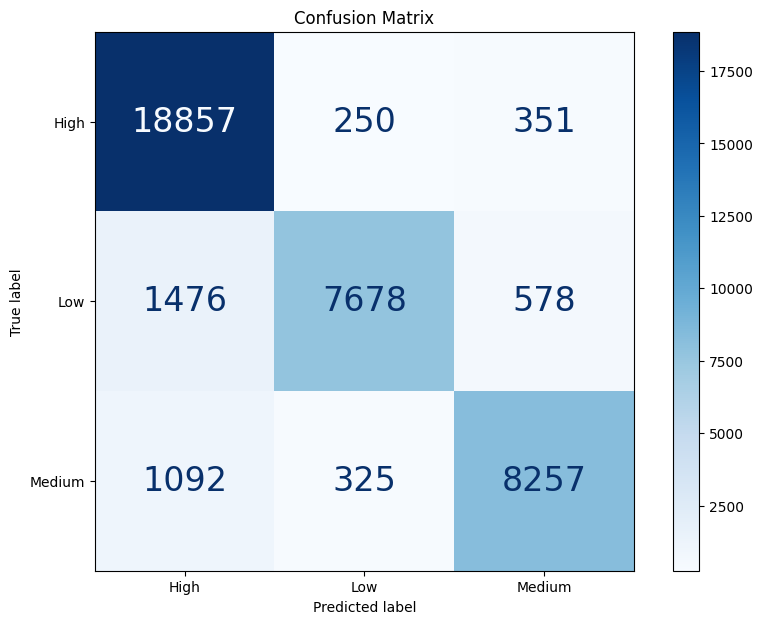

In [236]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=logreg_pipeline.classes_)

# Create a confusion matrix display object
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_pipeline.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
# Adjust font size of text in the matrix
for text in cmd.text_.ravel():
    text.set_fontsize(24)
plt.show()

In [224]:
# Aggregate transaction amounts by location
location_agg = transaction_level.groupby('location')['transaction_amount'].sum().reset_index()

# Sort the data for better visualization (optional)
location_agg = location_agg.sort_values(by='transaction_amount', ascending=False)

# Display the aggregated data
print(location_agg)

               location  transaction_amount
2878         Lake James           144270.81
5260          Port John           116965.42
7122         West David           105504.44
6331         South John            98751.03
3873    New Christopher            93394.23
...                 ...                 ...
1021        Dorseyshire               40.77
2806   Lake Deborahland               38.11
1378    East Kristopher               33.34
5130  Port Danielleside               29.92
600          Carterside               23.81

[7695 rows x 2 columns]


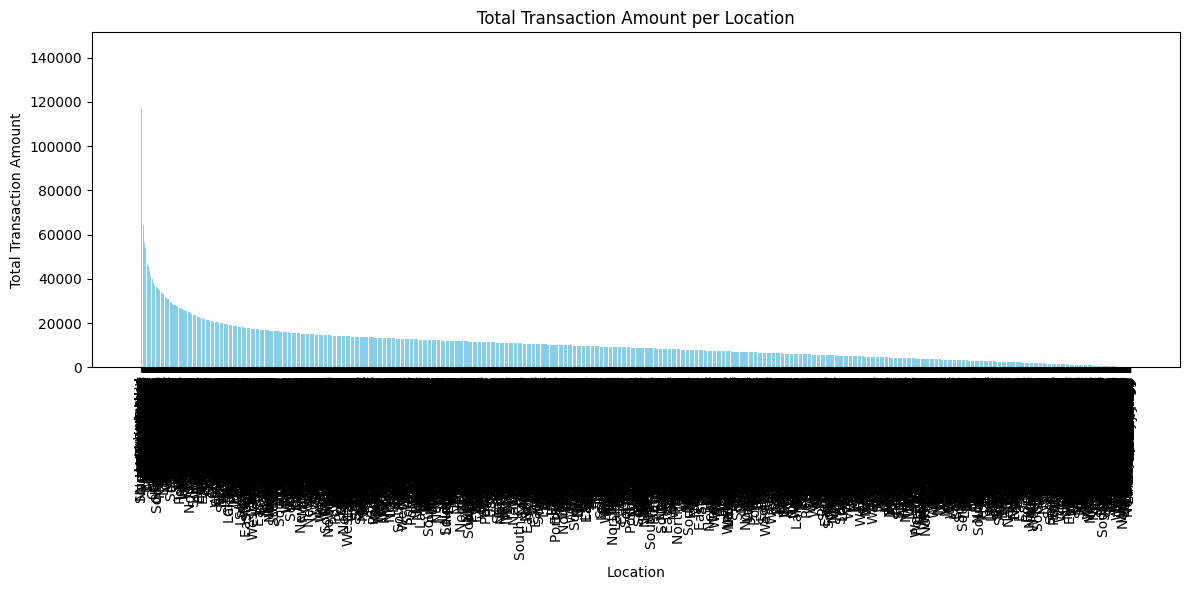

In [225]:
# Plot the data using a bar plot
plt.figure(figsize=(12, 6))
plt.bar(location_agg['location'], location_agg['transaction_amount'], color='skyblue')
plt.xlabel('Location')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amount per Location')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many locations
plt.tight_layout()
plt.show()

<Axes: ylabel='transaction_amount'>

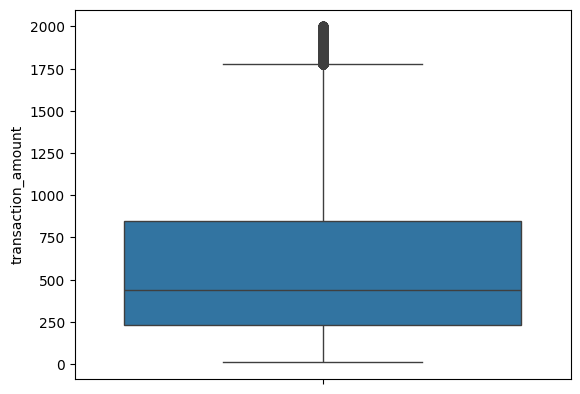

In [232]:
# Check Transaction_amount for outliers

sns.boxplot(transaction_level['transaction_amount'])

In [239]:
# look at values of top 40 transactions - to view outliers
print(transaction_level['transaction_amount'].sort_values(ascending=False).head(40))

73334     1999.99
1086      1999.99
36650     1999.92
95688     1999.91
18047     1999.91
36962     1999.78
124709    1999.76
5606      1999.74
35396     1999.71
75321     1999.62
116411    1999.61
46212     1999.53
97013     1999.51
7558      1999.43
107813    1999.32
94171     1999.27
4805      1999.25
105947    1999.25
76620     1999.20
9620      1999.18
11831     1999.18
69269     1999.17
2704      1999.16
44165     1998.93
68317     1998.90
106102    1998.87
111976    1998.86
71134     1998.84
90468     1998.84
96311     1998.71
73099     1998.57
129528    1998.54
43968     1998.53
117443    1998.49
37897     1998.49
2596      1998.48
18054     1998.47
87663     1998.36
73697     1998.31
52385     1998.27
Name: transaction_amount, dtype: float64


In [241]:
# describe distribution of transaction_amount

transaction_level['transaction_amount'].describe()

count    129545.000000
mean        597.287659
std         491.564174
min          10.020000
25%         228.320000
50%         438.380000
75%         846.980000
max        1999.990000
Name: transaction_amount, dtype: float64

In [242]:
# Take what we've learned to finalize the KNN model

# Create and train the KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # You can tune n_neighbors as needed
])

# Fit the model
knn_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['number_of_site_visits',
                                                   'number_of_emails_opened',
                                                   'number_of_clicks',
                                                   'transaction_amount',
                                                   'customer_lifespan']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['age_bins', 'gender',
                                                   'location'])])),
                ('classifier', KNeighborsClassifier())])

Classification Report for KNN:
               precision    recall  f1-score   support

         Low       0.96      1.00      0.98     19458
      Medium       1.00      0.91      0.95      9732
        High       0.98      1.00      0.99      9674

    accuracy                           0.98     38864
   macro avg       0.98      0.97      0.97     38864
weighted avg       0.98      0.98      0.98     38864

KNN Accuracy: 0.98
KNN Precision: 0.98
KNN Recall: 0.98
KNN F1 Score: 0.98


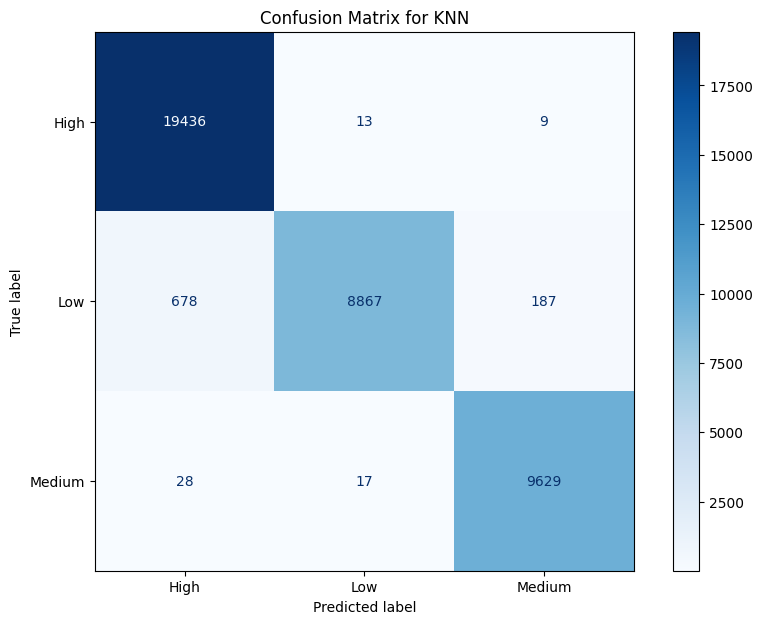

In [243]:
# Predict on the test data
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate the model
report_knn = classification_report(y_test, y_pred_knn, target_names=['Low', 'Medium', 'High'], zero_division=0)
print("Classification Report for KNN:\n", report_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN Precision: {precision_knn:.2f}")
print(f"KNN Recall: {recall_knn:.2f}")
print(f"KNN F1 Score: {f1_knn:.2f}")

# Generate the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=knn_pipeline.named_steps['classifier'].classes_)

# Create a confusion matrix display object
cmd_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn_pipeline.named_steps['classifier'].classes_)

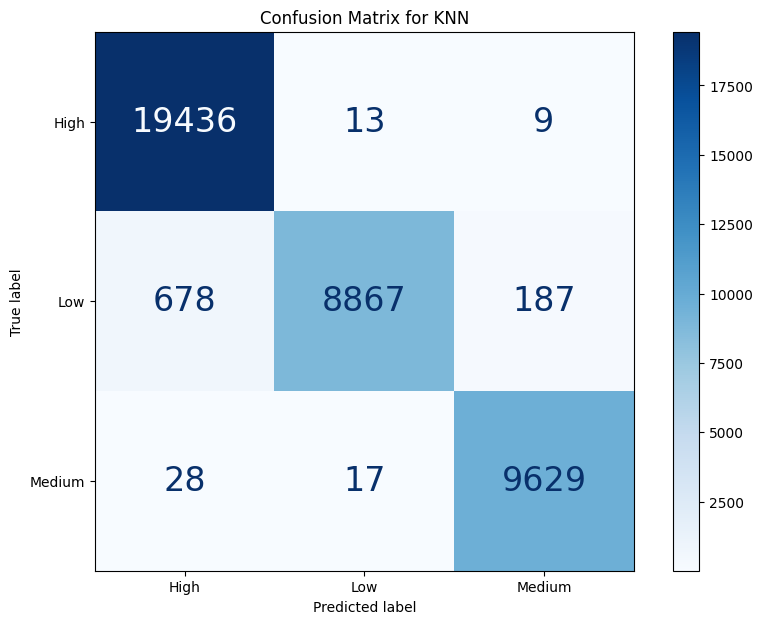

In [245]:
# Plot the confusion matrix with a larger font for labels
fig, ax = plt.subplots(figsize=(10, 7))
cmd_knn.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
# Adjust font size of text in the matrix
for text in cmd_knn.text_.ravel():
    text.set_fontsize(24)
plt.show()

In [247]:
# Define the preprocessor (assuming you have already defined it)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ]
)

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define a reduced parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Perform grid search with cross-validation
grid_search_knn = GridSearchCV(knn_pipeline, param_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found by grid search:")
print(grid_search_knn.best_params_)

C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
31 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packa

Best parameters found by grid search:
{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}


In [248]:
# Re Test KNN with the best parameters as found with Grid Search

# Create and train the KNN pipeline with the best parameters
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=3, 
        weights='uniform', 
        metric='euclidean'
    ))
])

# Fit the model with the best parameters
knn_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate the model
report_knn = classification_report(y_test, y_pred_knn, target_names=['Low', 'Medium', 'High'], zero_division=0)
print("Classification Report for KNN:\n", report_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)

print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN Precision: {precision_knn:.2f}")
print(f"KNN Recall: {recall_knn:.2f}")
print(f"KNN F1 Score: {f1_knn:.2f}")


Classification Report for KNN:
               precision    recall  f1-score   support

         Low       0.98      1.00      0.99     19458
      Medium       1.00      0.95      0.97      9732
        High       0.99      1.00      0.99      9674

    accuracy                           0.99     38864
   macro avg       0.99      0.98      0.98     38864
weighted avg       0.99      0.99      0.99     38864

KNN Accuracy: 0.99
KNN Precision: 0.99
KNN Recall: 0.99
KNN F1 Score: 0.99


ROC AUC Score (OvR): 1.00


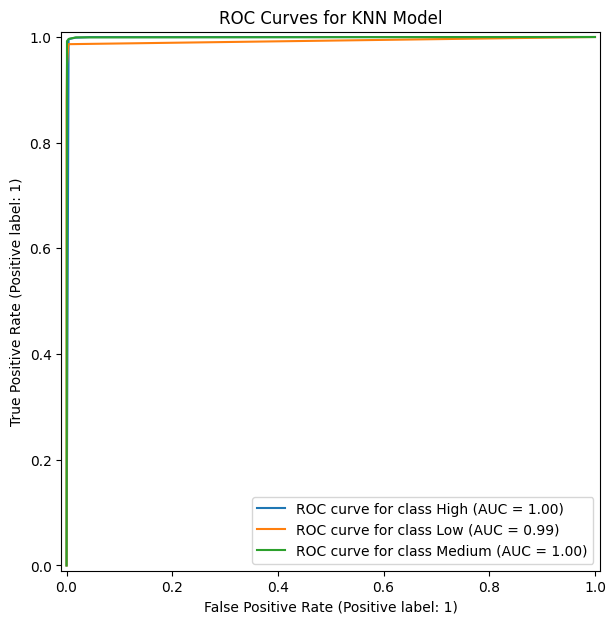

In [250]:
# Predict probabilities on the test data
y_proba_knn = knn_pipeline.predict_proba(X_test)

# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=knn_pipeline.named_steps['classifier'].classes_)

# Compute ROC AUC for each class
roc_auc_ovr = roc_auc_score(y_test_binarized, y_proba_knn, multi_class='ovr')

print(f"ROC AUC Score (OvR): {roc_auc_ovr:.2f}")

# Plot ROC curves for each class
fig, ax = plt.subplots(figsize=(10, 7))

for i, class_label in enumerate(knn_pipeline.named_steps['classifier'].classes_):
    RocCurveDisplay.from_predictions(y_test_binarized[:, i], y_proba_knn[:, i], name=f"ROC curve for class {class_label}", ax=ax)

plt.title("ROC Curves for KNN Model")
plt.show()

In [252]:
# Verify models using correct data, (further investigate overfitting)
X_test

,age_bins,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_amount,customer_lifespan
101503,50-64,Female,West Ericton,11,17,18,774.96,296
110841,50-64,Male,Montesberg,56,34,8,365.75,215
80136,50-64,Female,Dianashire,43,22,6,181.64,119
18786,35-49,Male,Matthewhaven,14,6,1,91.56,35
97269,65+,Female,Turnerborough,83,19,42,405.60,490
...,...,...,...,...,...,...,...,...
73906,65+,Female,Jillshire,43,19,59,199.25,1320
96640,65+,Male,Garzaville,9,13,23,310.90,258
115757,35-49,Male,Melissaton,6,1,1,1512.84,20
7519,50-64,Female,Mcdonaldtown,27,7,1,1857.64,67


In [253]:
# Verify models using correct data, (further investigate overfitting)

X_train

,age_bins,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_amount,customer_lifespan
63362,35-49,Male,Port Paul,248,86,52,326.23,824
90481,65+,Female,Lake Thomashaven,2,4,1,716.01,101
116527,35-49,Male,Herreraville,554,197,39,297.64,1418
99866,35-49,Male,New Tracymouth,6,9,6,935.02,86
25029,35-49,Female,Anthonychester,31,52,10,61.84,278
...,...,...,...,...,...,...,...,...
97727,50-64,Female,Port Martinberg,16,5,6,67.98,128
56745,50-64,Male,Jimenezborough,30,74,8,1121.27,377
120276,35-49,Male,Lake Andrewport,242,122,22,522.38,1424
52830,NaN,Male,South Jacob,81,16,4,842.15,164


In [254]:
# Verify models using correct data, (further investigate overfitting)

X

,age_bins,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_amount,customer_lifespan
5,50-64,Female,North Shannonbury,10,15,1,174.72,118
3,50-64,Female,North Shannonbury,10,15,1,927.46,118
0,50-64,Female,North Shannonbury,10,15,1,165.56,118
4,50-64,Female,North Shannonbury,10,15,1,1395.87,118
1,50-64,Female,North Shannonbury,10,15,1,699.01,118
...,...,...,...,...,...,...,...,...
129544,65+,Male,Hollytown,12,12,7,452.07,98
129539,65+,Male,Hollytown,12,12,7,310.95,98
129543,65+,Male,Hollytown,12,12,7,587.37,98
129538,65+,Male,Hollytown,12,12,7,34.85,98


In [255]:
# Verify models using correct data, (further investigate overfitting)

y

5         Low
3         Low
0         Low
4         Low
1         Low
         ... 
129544    Low
129539    Low
129543    Low
129538    Low
129535    Low
Name: LTV_cat, Length: 129545, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [256]:
# Verify models using correct data, (further investigate overfitting)

y_test

101503       Low
110841      High
80136       High
18786     Medium
97269       High
           ...  
73906       High
96640        Low
115757       Low
7519        High
119047       Low
Name: LTV_cat, Length: 38864, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [257]:
# Verify models using correct data, (further investigate overfitting)

y_train

63362       High
90481        Low
116527       Low
99866     Medium
25029       High
           ...  
97727       High
56745       High
120276      High
52830       High
2213      Medium
Name: LTV_cat, Length: 90681, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [264]:
# Examine Marketing Performance for each LTV_cat

# First need to bring the LTV_cat variable over to df_merged

# Define the LTV bins and labels
ltv_bins = [0, 7134.53, 10324.62, float('inf')]
ltv_labels = ['Low', 'Medium', 'High']

# Create the LTV_cat column in the transaction_level DataFrame
df_merged['LTV_cat'] = pd.cut(df_merged['LTV'], bins=ltv_bins, labels=ltv_labels, right=False)

In [265]:
# Verify same as transactional_level 

df_merged['LTV_cat'].value_counts()

LTV_cat
High      64777
Medium    32385
Low       32383
Name: count, dtype: int64

In [266]:
df_merged.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'LTV', 'age_bins',
       'customer_lifespan', 'LTV_cat', 'campaign_customer_id',
       'campaign_campaign_id', 'campaign_response', 'campaign_promotion_type',
       'campaign_campaign_date'],
      dtype='object')

In [275]:
df_merged['campaign_promotion_type'].value_counts()

campaign_promotion_type
Buy One Get One    30558
Discount           29947
Free Shipping      29484
Name: count, dtype: int64

In [270]:
# Find the valuecounts for each campaign_id and promotion_type for High value customers who responded 'yes' to the campaign

# Filter the DataFrame for the required conditions
filtered_df = df_merged[(df_merged['LTV_cat'] == 'High') & (df_merged['campaign_response'] == 'Yes')]

# Group by 'campaign_campaign_id' and 'campaign_promotion_type' and count the occurrences
value_counts = filtered_df.groupby(['campaign_campaign_id', 'campaign_promotion_type']).size().reset_index(name='count')

# Display the result
print(value_counts)

      campaign_campaign_id campaign_promotion_type  count
0                     25.0         Buy One Get One      2
1                     28.0           Free Shipping      9
2                     37.0         Buy One Get One      9
3                     38.0                Discount      7
4                     39.0                Discount     12
...                    ...                     ...    ...
3440               25174.0         Buy One Get One      1
3441               25179.0                Discount      4
3442               25180.0           Free Shipping      5
3443               25184.0           Free Shipping      6
3444               25185.0         Buy One Get One      3

[3445 rows x 3 columns]


In [276]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'High') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_promotion_type'].value_counts()

# Display the result
print(promotion_type_counts)

campaign_promotion_type
Buy One Get One    7780
Free Shipping      7505
Discount           7378
Name: count, dtype: int64


In [281]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'High') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_campaign_id'].value_counts()

# Display the result
print(promotion_type_counts.head(20))

campaign_campaign_id
347.0      25
4839.0     25
15418.0    25
17118.0    25
21514.0    24
5707.0     24
2144.0     24
12801.0    24
11462.0    24
15163.0    24
19258.0    24
406.0      24
533.0      24
13013.0    23
21430.0    23
11367.0    23
20876.0    23
19597.0    23
7721.0     23
19878.0    23
Name: count, dtype: int64


In [278]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'Medium') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_promotion_type'].value_counts()

# Display the result
print(promotion_type_counts)

campaign_promotion_type
Buy One Get One    3819
Discount           3684
Free Shipping      3457
Name: count, dtype: int64


In [283]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'Medium') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_campaign_id'].value_counts()

# Display the result
print(promotion_type_counts.head(20))

campaign_campaign_id
2352.0     24
8096.0     22
1978.0     22
14893.0    21
16027.0    21
8924.0     21
5791.0     21
23334.0    20
21928.0    20
2978.0     19
13384.0    19
16303.0    19
19146.0    19
12678.0    19
1436.0     18
19364.0    18
11371.0    18
23237.0    18
8054.0     18
5183.0     17
Name: count, dtype: int64


In [279]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'Low') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_promotion_type'].value_counts()

# Display the result
print(promotion_type_counts)

campaign_promotion_type
Buy One Get One    3909
Free Shipping      3684
Discount           3667
Name: count, dtype: int64


In [284]:
# Filter the DataFrame for the required conditions and drop duplicates based on 'customer_id'
filtered_df = df_merged[(df_merged['LTV_cat'] == 'Low') & (df_merged['campaign_response'] == 'Yes')]

# Count the occurrences for each promotion type
promotion_type_counts = filtered_df['campaign_campaign_id'].value_counts()

# Display the result
print(promotion_type_counts.head(20))

campaign_campaign_id
15401.0    17
24551.0    16
3197.0     16
9798.0     15
9310.0     14
18424.0    14
12754.0    13
16567.0    13
2565.0     13
5206.0     13
22750.0    13
22596.0    13
13197.0    13
12732.0    12
12225.0    12
7155.0     12
1798.0     12
15549.0    12
24197.0    12
23202.0    12
Name: count, dtype: int64
